# <b>Monocytes scDRS
This notebook was created for monocytes scDRS analysis of two GWAS traits for the purpose of creating postive controls which can be used in future analysis. These traits are the following: 
- Percentage of white cells that are monocytes
- Count of monocytes per unit volume of blood


In [ ]:
# imports
import scdrs
import anndata as an
import scanpy as sc
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import sys
sys.path.append("../Src")
from scdrs_utils import find_marker_genes, analyze_variant_scores 
import warnings

plt.rcParams['figure.figsize'] = [2.5, 2.5]
plt.rcParams['figure.dpi'] = 150

warnings.filterwarnings("ignore")

In [3]:
# Data directories
SCDRS_DIR = Path("../Data/SCDRS")
RESULTS_DIR = Path("../Results")

mono_marker_genes = ["CTSS", "FCN1", "NEAT1", "LYZ", "PSAP", "S100A9", "AIF1", "MNDA", "SERPINA1", "TYROBP"]

# Save results?

<H1> ..</H1>

In [4]:
adata.layers["counts"] = adata.X.copy()
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]

sc.pp.scale(adata, max_value=10)
# NOTE: " each putative disease gene is weighted by its 
# GWAS MAGMA z-score and inversely weighted by its gene-specific 
# technical noise level in the single-cell data, estimated via modeling 
# the mean-variance relationship across genes"
# sc.pp.scale flattens mean-variance relationship, so is it better to not do this step? 
# the tutorial does do the scaling step.

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
# sc.tl.leiden(adata)
scdrs.preprocess(adata, cov=df_cov, n_mean_bin=20, n_var_bin=20, copy=False)

Too few genes for 20*20 bins, setting n_mean_bin=n_var_bin=14


In [ ]:
geneset_variants = {
    "canon" : SCDRS_DIR / "genesets" / "GS1000_mono_p-mono_c_W5,5.gs", # Canonical control geneset
    "control_1" : SCDRS_DIR / "genesets" / "GS_control_1_mono_p-mono_c_5,5.gs", # Markers high (30), all others low (0.1)
    "control_2" : SCDRS_DIR / "genesets" / "GS_control_2_mono_p-mono_c_5,5.gs", # Markers high (30), all others unchanged
    "control_3" : SCDRS_DIR / "genesets" / "GS_control_3_mono_p-mono_c_5,5.gs", # Markers high (30), added if missing
}
# Load genesets
for name, geneset in geneset_variants.items():
    loaded_geneset = scdrs.util.load_gs(
        geneset,
        src_species="human",
        dst_species="human",
        to_intersect=adata.var_names,
        
    )
    # Replace file path with geneset data
    geneset_variants[name] = loaded_geneset

print(f"Genesets loaded for: {", ".join(geneset_variants.keys())}")

In [ ]:
# Negative control height geneset in mouse, there might be better alternatives
# Loading geneset, scoring cells and writing to .csv for later use

mouse_height = scdrs.util.load_gs(
    SCDRS_DIR / "tutorial" / "mouse_height.gs",
    src_species="mouse",
    dst_species="human",
    to_intersect=adata.var_names,
)

gene_list, gene_weights = mouse_height["Height"]

mouse_height_scores = scdrs.score_cell(
    data=adata,
    gene_list=gene_list,
    gene_weight=gene_weights,
    ctrl_match_key="mean_var",
    n_ctrl=1000,
    weight_opt="vs",
    return_ctrl_raw_score=False,
    return_ctrl_norm_score=True,
    verbose=False,
)

adata.obs["Height"] = mouse_height_scores["norm_score"]

In [ ]:
find_marker_genes(geneset_variants, mono_marker_genes)

In [ ]:
variant_scores = {}

for variant_name, genesets in geneset_variants.items():
    dict_df_score = {}
    for trait in genesets:
        gene_list, gene_weights = genesets[trait]
        dict_df_score[trait] = scdrs.score_cell(
            data=adata,
            gene_list=gene_list,
            gene_weight=gene_weights,
            ctrl_match_key="mean_var",
            n_ctrl=1000,
            weight_opt="vs",
            return_ctrl_raw_score=False,
            return_ctrl_norm_score=True,
            verbose=False,
        )
    
    variant_scores[variant_name] = dict_df_score    

In [ ]:
# NOTE: predicted.mo_10x_cell_type.lowerres, celltype_imputed_lowerres, celltype_imputed
sc.pl.umap(
        adata,
        color=["celltype_imputed_lowerres", "celltype_imputed", "batch", "sample_final"],
        ncols=2,
        color_map="RdBu_r",
        vmin=-5,
        vmax=5,
        wspace=0.7
)

In [ ]:
analyze_variant_scores(adata, variant_scores)

Much more significant cells after after adding sex, age and batch covariates, especially for control_1.

In [ ]:
monocyte_degs = ['PLXDC2', 'ZEB2', 'NEAT1', 'ARHGAP26', 'FAM49A', 'IRAK3', 'LYN', 'KYNU', 'SAT1', 'LRMDA']
        
degs_genesets = {
    "degs_1" : SCDRS_DIR / "genesets" / "DEGS_control_1_mono_p-mono_c_5,5.gs", # Markers high (30), all others low (0.1)
    "degs_2" : SCDRS_DIR / "genesets" / "DEGS_control_2_mono_p-mono_c_5,5.gs", # Markers high (30), all others unchanged
    "degs_3" : SCDRS_DIR / "genesets" / "DEGS_control_3_mono_p-mono_c_5,5.gs", # Markers high (30), added if missing
}
# Load genesets
for name, geneset in degs_genesets.items():
    loaded_geneset = scdrs.util.load_gs(
        geneset,
        src_species="human",
        dst_species="human",
        to_intersect=adata.var_names,
    )
    # Replace file path with geneset data
    degs_genesets[name] = loaded_geneset

print(f"Genesets loaded for: {", ".join(degs_genesets.keys())}")

In [ ]:
find_marker_genes(degs_genesets, monocyte_degs)

In [ ]:
variant_scores = {}

for variant_name, genesets in degs_genesets.items():
    dict_df_score = {}
    for trait in genesets:
        gene_list, gene_weights = genesets[trait]
        dict_df_score[trait] = scdrs.score_cell(
            data=adata,
            gene_list=gene_list,
            gene_weight=gene_weights,
            ctrl_match_key="mean_var",
            n_ctrl=1000,
            weight_opt="vs",
            return_ctrl_raw_score=False,
            return_ctrl_norm_score=True,
            verbose=False,
        )
    
    variant_scores[variant_name] = dict_df_score    

In [ ]:
group = "celltype_imputed_lowerres"

# Height scores
        adata.obs[f"{variant}_{trait}"] = dict_df_score[trait]["norm_score"]
        
        df_stats = scdrs.method.downstream_group_analysis(
            adata=adata,
            df_full_score=dict_df_score[trait],
            group_cols=[group],
        )[group]
    
        display(df_stats.style.set_caption(f"Group-level statistics for {variant} - {trait}"))
for variant, dict_df_score in variant_scores.items():
    for trait in dict_df_score:
        
        adata.obs[f"{variant}_{trait}"] = dict_df_score[trait]["norm_score"]
        
        df_stats = scdrs.method.downstream_group_analysis(
            adata=adata,
            df_full_score=dict_df_score[trait],
            group_cols=[group],
        )[group]
    
        display(df_stats.style.set_caption(f"Group-level statistics for {variant} - {trait}"))
    
    sc.pl.umap(
        adata,
        title=[f"{variant} - {trait}" for trait in dict_df_score.keys()] + ["Height"],
        color=[f"{variant}_{trait}" for trait in dict_df_score.keys()] + ["Height"],
        color_map="RdBu_r",
        vmin=-5,
        vmax=5,
        s=20,
    )
    print("\n\n")

Results seem lackluster, altough assoc_mcp < 0.05 for monocytes in some cases. No significantly associated cells for the most part though, so this significant association is a little bit puzzeling. Also, only two DEGs remain after filtering so the identified ten DEGs arent reflected very well here. Let's try a different filtering approach. 

In [ ]:
# Reload files
adata = an.concat([
    scdrs.util.load_h5ad(
        h5ad_file=file, flag_filter_data=True, flag_raw_count=True
    ) for file in h5ad_files
])
print(adata.var_keys)

In [ ]:
# No highly variable genes filter
# No sc.pp.scale
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
scdrs.preprocess(adata, cov=df_cov, n_mean_bin=20, n_var_bin=20, copy=False)

In [ ]:
# NOTE: predicted.mo_10x_cell_type.lowerres, celltype_imputed_lowerres, celltype_imputed
sc.pl.umap(
        adata,
        color=["celltype_imputed_lowerres", "celltype_imputed", "batch", "sample_final"],
        ncols=2,
        color_map="RdBu_r",
        vmin=-5,
        vmax=5,
        wspace=0.7
)

In [ ]:
variant_scores = {}

for variant_name, genesets in geneset_variants.items():
    dict_df_score = {}
    for trait in genesets:
        gene_list, gene_weights = genesets[trait]
        dict_df_score[trait] = scdrs.score_cell(
            data=adata,
            gene_list=gene_list,
            gene_weight=gene_weights,
            ctrl_match_key="mean_var",
            n_ctrl=1000,
            weight_opt="vs",
            return_ctrl_raw_score=False,
            return_ctrl_norm_score=True,
            verbose=False,
        )
    
    variant_scores[variant_name] = dict_df_score    

In [ ]:
group = "celltype_imputed_lowerres"

for variant, dict_df_score in variant_scores.items():
    for trait in dict_df_score:
        
        adata.obs[f"{variant}_{trait}"] = dict_df_score[trait]["norm_score"]
        
        df_stats = scdrs.method.downstream_group_analysis(
            adata=adata,
            df_full_score=dict_df_score[trait],
            group_cols=[group],
        )[group]
    
        display(df_stats.style.set_caption(f"Group-level statistics for {variant} - {trait}"))
    
    sc.pl.umap(
        adata,
        title=[f"{variant} - {trait}" for trait in dict_df_score.keys()],
        color=[f"{variant}_{trait}" for trait in dict_df_score.keys()],
        color_map="RdBu_r",
        vmin=-5,
        vmax=5,
        s=20,
    )
    print("\n\n")

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
scdrs.preprocess(adata, cov=df_cov, n_mean_bin=20, n_var_bin=20, copy=False)

In [ ]:
variant_scores = {}

for variant_name, genesets in geneset_variants.items():
    dict_df_score = {}
    for trait in genesets:
        gene_list, gene_weights = genesets[trait]
        dict_df_score[trait] = scdrs.score_cell(
            data=adata,
            gene_list=gene_list,
            gene_weight=gene_weights,
            ctrl_match_key="mean_var",
            n_ctrl=1000,
            weight_opt="vs",
            return_ctrl_raw_score=False,
            return_ctrl_norm_score=True,
            verbose=False,
        )
    
    variant_scores[variant_name] = dict_df_score    

In [ ]:
group = "celltype_imputed_lowerres"

for variant, dict_df_score in variant_scores.items():
    for trait in dict_df_score:
        
        adata.obs[f"{variant}_{trait}"] = dict_df_score[trait]["norm_score"]
        
        df_stats = scdrs.method.downstream_group_analysis(
            adata=adata,
            df_full_score=dict_df_score[trait],
            group_cols=[group],
        )[group]
    
        display(df_stats.style.set_caption(f"Group-level statistics for {variant} - {trait}"))
    
    sc.pl.umap(
        adata,
        title=[f"{variant} - {trait}" for trait in dict_df_score.keys()],
        color=[f"{variant}_{trait}" for trait in dict_df_score.keys()],
        color_map="RdBu_r",
        vmin=-5,
        vmax=5,
        s=20,
    )
    print("\n\n")

# 1. Filtering on aggregated subsets instead of on a per-subset basis

Previously, cells were filtered on a per-subset basis, which can pre-emptively cut genes with low read counts, that may have high read counts in another celltype. The consequence of this was that certain marker genes were cut marker genes were cut that i would like to keep to maximize the effect. Here, filtering is done using the default parameters used by scDRS.

### 1.1 Read expression data

In [16]:
# single nucleus RNA-seq expression data
variant_scores = {}
all_stats_df = {}

h5ad_files = [
    SCDRS_DIR / "multiome" / "Mono_subset_UT.h5ad",
    SCDRS_DIR / "multiome" / "CD4_T_subset_UT.h5ad"
]

adata = an.concat([
    scdrs.util.load_h5ad(
        h5ad_file=file
    ) for file in h5ad_files
])

# Filter cells according to scDRS default and normalize read counts and log transform, normally done by laod h5ad function
sc.pp.filter_cells(adata, min_genes=250)
sc.pp.filter_genes(adata, min_cells=50)

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

# load covariates
df_cov = adata.obs[["n_genes", "SEX", "age", "batch"]].copy()
df_cov["batch"] = df_cov["batch"].astype("category").cat.codes

adata.obs_keys()

['orig.ident',
 'nCount_RNA_v5',
 'nFeature_RNA_v5',
 'nCount_RNA',
 'nFeature_RNA',
 'barcode',
 'barcode_1',
 'barcode_lane',
 'lane',
 'batch',
 'percent.mt',
 'nCount_RNA_mad',
 'nFeature_RNA_mad',
 'confined_best_match_sample',
 'confined_second_match_sample',
 'confined_best_match_correlation',
 'confined_second_match_correlation',
 'confined_condition',
 'unconfined_best_match_sample',
 'unconfined_second_match_sample',
 'unconfined_best_match_correlation',
 'unconfined_second_match_correlation',
 'unconfined_condition',
 'soup_cluster',
 'soup_status',
 'soup_singlet_posterior',
 'soup_doublet_posterior',
 'soup_log_prob_singleton',
 'soup_log_prob_doublet',
 'soup_cluster0',
 'soup_cluster1',
 'soup_cluster2',
 'soup_cluster3',
 'soup_cluster4',
 'soup_cluster5',
 'soup_cluster6',
 'soup_cluster7',
 'sample_final',
 'final_condition',
 'predicted.mo_10x_cell_type',
 'predicted.mo_10x_cell_type.score',
 'predicted.mo_10x_cell_type.lowerres',
 'nCount_SCT',
 'nFeature_SCT',
 'SC

### 1.2 Load geneset

In [7]:
geneset_variants = {
    "canon" : SCDRS_DIR / "genesets" / "N1000_mono_p-mono_c-P-mono_c-P-mono_p-N-mono_p-N-mono_c_W5,5.gs",
    "DEGs" : SCDRS_DIR / "genesets" / "N1000_DEGs.gs"
}

# Load genesets
for name, geneset in geneset_variants.items():
    loaded_geneset = scdrs.util.load_gs(
        geneset,
        src_species="human",
        dst_species="human",
        to_intersect=adata.var_names,
        
    )
    # Replace file path with geneset data
    geneset_variants[name] = loaded_geneset

print(f"Genesets loaded for: {', '.join(geneset_variants.keys())}")

Genesets loaded for: canon, DEGs


### 1.3 Preprocess data

In [12]:
adata.layers["counts"] = adata.X.copy()
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3.5, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

sc.pp.scale(adata)
# NOTE: " each putative disease gene is weighted by its 
# GWAS MAGMA z-score and inversely weighted by its gene-specific 
# technical noise level in the single-cell data, estimated via modeling 
# the mean-variance relationship across genes"
# sc.pp.scale flattens mean-variance relationship, so is it better to not do this step? 
# the tutorial does do the scaling step.



sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
# sc.tl.leiden(adata)
scdrs.preprocess(adata, cov=df_cov, n_mean_bin=20, n_var_bin=20, copy=False)

/groups/umcg-franke-scrna/tmp02/users/umcg-hdijkstra/scscore/lib64/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Too few genes for 20*20 bins, setting n_mean_bin=n_var_bin=3


In [18]:
print(df_cov)

                               n_genes  SEX  age  batch
CTAAGTCAGGGTGAAC_230105_lane1     4180  1.0   34      0
CTGTTGGAGTGACCTG_230105_lane1     3737  1.0   34      0
AGCACAGCACTCAACA_230105_lane1      473  1.0   34      0
CATATCGCACAACCTA_230105_lane1      347  1.0   34      0
TTAGAAGCAAGATTCT_230105_lane1      354  1.0   34      0
...                                ...  ...  ...    ...
ACGTTACAGAAACTGG_230316_lane8      780  2.0   61      3
GAAAGCCAGTGAACCT_230316_lane8      774  2.0   56      3
ACTTAGGGTAATAACC_230316_lane8     1065  2.0   56      3
CGGCCATAGGAGTAAT_230316_lane8      891  2.0   61      3
TGGGCCTAGTCAGGCC_230316_lane8      323  2.0   61      3

[4743 rows x 4 columns]


### 11.2 Generate height negative control

In [8]:
# Negative control height geneset in mouse, there might be better alternatives

mouse_height = scdrs.util.load_gs(
    SCDRS_DIR / "tutorial" / "mouse_height.gs",
    src_species="mouse",
    dst_species="human",
    to_intersect=adata.var_names,
)

gene_list, gene_weights = mouse_height["Height"]

mouse_height_scores = scdrs.score_cell(
    data=adata,
    gene_list=gene_list,
    gene_weight=gene_weights,
    ctrl_match_key="mean_var",
    n_ctrl=1000,
    weight_opt="vs",
    return_ctrl_raw_score=False,
    return_ctrl_norm_score=True,
    verbose=False,
)

adata.obs["Height"] = mouse_height_scores["norm_score"]

Computing control scores: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:59<00:00, 16.84it/s]


In [9]:
group = "celltype_imputed_lowerres"
mouse_stats = scdrs.method.downstream_group_analysis(
    adata=adata,
    df_full_score=mouse_height_scores,
    group_cols=[group],
    )[group]

display(mouse_stats.style.set_caption(f"Group-level statistics for Height"))

,n_cell,n_ctrl,assoc_mcp,assoc_mcz,hetero_mcp,hetero_mcz,n_fdr_0.05,n_fdr_0.1,n_fdr_0.2
group,,,,,,,,,
CD4T,2056.000000,1000.000000,0.613387,-0.290938,0.509490,-0.051921,0.000000,0.000000,0.000000
monocyte,2687.000000,1000.000000,0.329670,0.382703,0.421578,0.067502,0.000000,0.000000,0.000000


<h2>Score cells</h2>

In [11]:
for variant_name, genesets in geneset_variants.items():
    dict_df_score = {}
    for trait in genesets:
        gene_list, gene_weights = genesets[trait]
        dict_df_score[trait] = scdrs.score_cell(
            data=adata,
            gene_list=gene_list,
            gene_weight=gene_weights,
            ctrl_match_key="mean_var",
            n_ctrl=1000,
            weight_opt="vs",
            return_ctrl_raw_score=False,
            return_ctrl_norm_score=True,
            verbose=False,
        )
    
    variant_scores[variant_name] = dict_df_score    

Computing control scores: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:09<00:00, 14.39it/s]


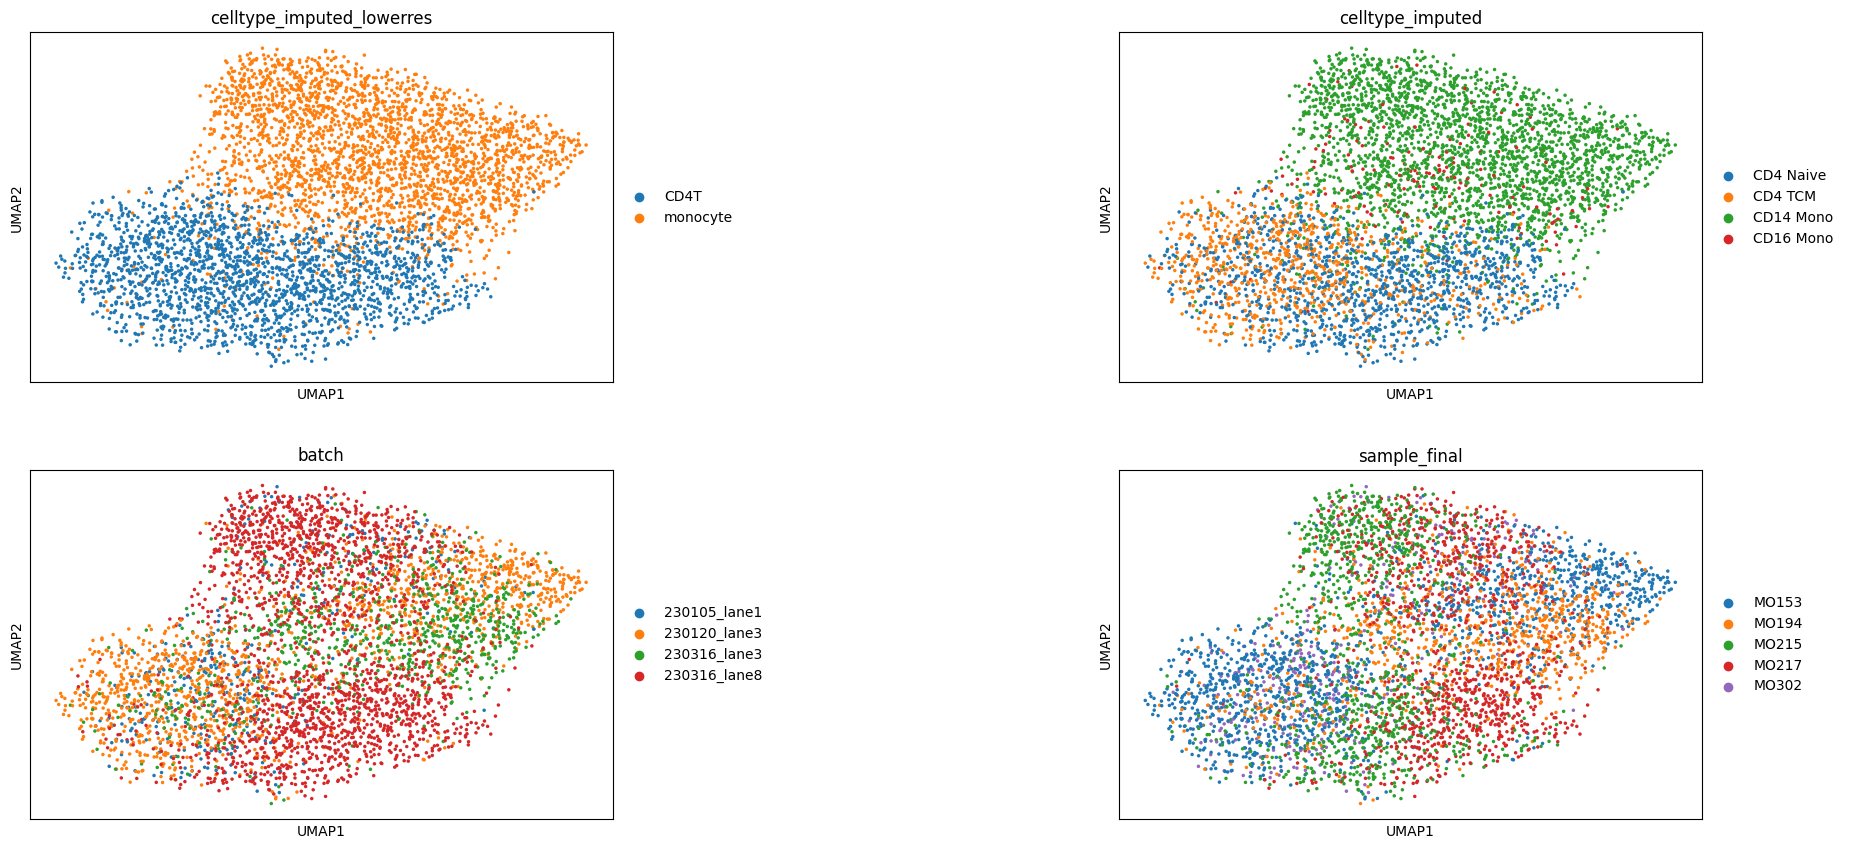

In [13]:
# NOTE: predicted.mo_10x_cell_type.lowerres, celltype_imputed_lowerres, celltype_imputed
sc.pl.umap(
        adata,
        color=["celltype_imputed_lowerres", "celltype_imputed", "batch", "sample_final"],
        ncols=2,
        color_map="RdBu_r",
        vmin=-5,
        vmax=5,
        wspace=0.7
)

,n_cell,n_ctrl,assoc_mcp,assoc_mcz,hetero_mcp,hetero_mcz,n_fdr_0.05,n_fdr_0.1,n_fdr_0.2
group,,,,,,,,,
CD4T,2056.000000,1000.000000,1.000000,-27.214609,0.000999,21.218262,2.000000,2.000000,2.000000
monocyte,2687.000000,1000.000000,0.000999,74.052887,0.000999,19.767879,2347.000000,2367.000000,2383.000000


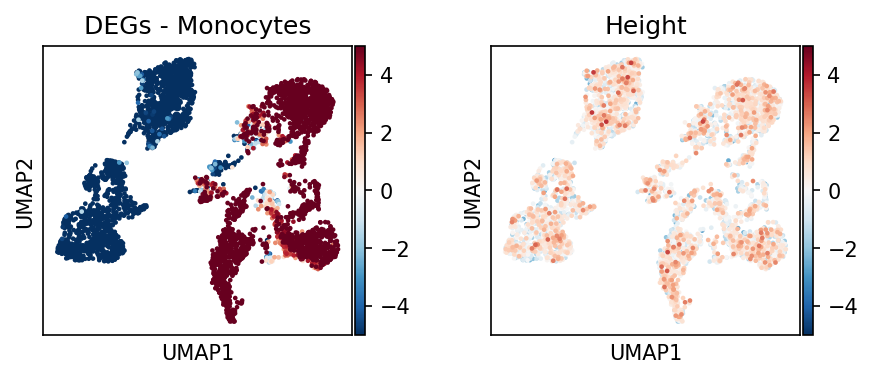

In [15]:
group = "celltype_imputed_lowerres"
title_map = {
    "mono_p"   : "Mono Percentage",
    "mono_c"   : "Mono Count",
    "P-mono_p" : "Mono Percentage (+β)",
    "P-mono_c" : "Mono Count (+β)",
    "N-mono_c" : "Mono Count (-β)",
    "N-mono_p" : "Mono Percentage (-β)",
    "DEGs" : "Monocytes"
}
for variant, dict_df_score in variant_scores.items():
    all_stats_df[variant] = {}    
    for trait in dict_df_score:
        if trait not in all_stats_df[variant]: 
            adata.obs[f"{variant}_{trait}"] = dict_df_score[trait]["norm_score"]

            stats_df = scdrs.method.downstream_group_analysis(
                adata=adata,
                df_full_score=dict_df_score[trait],
                group_cols=[group],
            )[group]

            all_stats_df[variant][trait] = stats_df
        else:
            stats_df = all_stats_df[variant][trait]
        
        
        display(stats_df.style.set_caption(f"Group-level statistics for {variant} - {title_map[trait]}"))
        
    sc.pl.umap(
        adata,
        title=[f"{variant} - {title_map[trait]}" for trait in dict_df_score.keys()] + ["Height"],
        color=[f"{variant}_{trait}" for trait in dict_df_score.keys()] + ["Height"],
        color_map="RdBu_r",
        vmin=-5,
        vmax=5,
        s=20,
        ncols=2
    )
    print("\n\n")

TypeError: cannot unpack non-iterable NoneType object

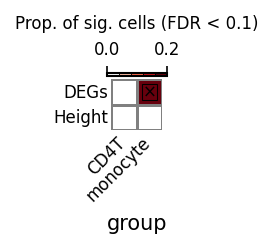

In [16]:
for trait, stats in all_stats_df.items():
    stats["Height"] =  mouse_stats
    fig, ax = scdrs.util.plot_group_stats(
        dict_df_stats=stats
    )

In [ ]:
for trait, stats in all_stats_df.items():
    stats["Height"] =  mouse_stats
    fig, ax = scdrs.util.plot_group_stats(
        dict_df_stats=stats
    )

## 2. DEGs 

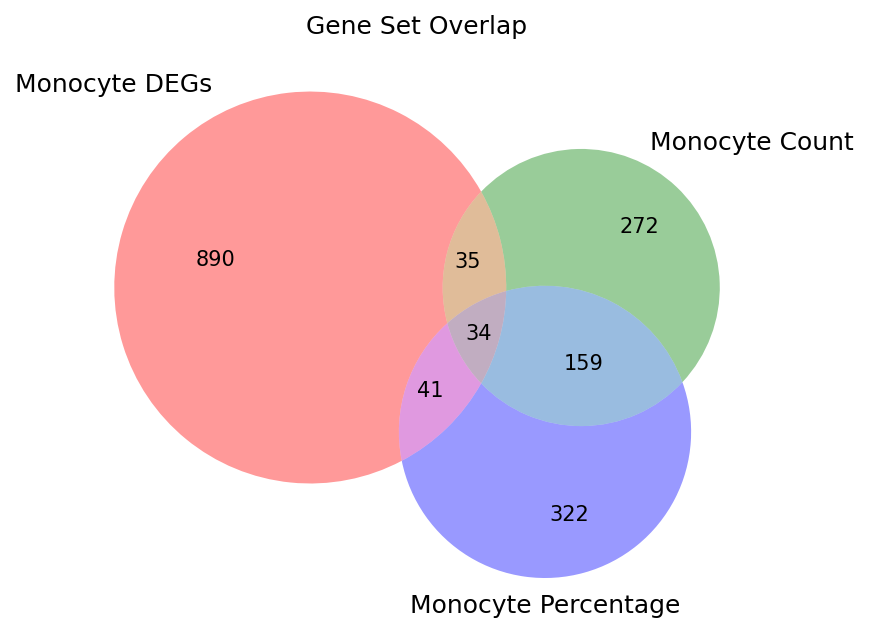

In [49]:
from matplotlib_venn import venn3

deg_genes = set(geneset_variants["DEGs"]["DEGs"][0])
mono_c_genes = set(geneset_variants["canon"]["mono_c"][0])
mono_p_genes = set(geneset_variants["canon"]["mono_p"][0])

# Create the Venn diagram
plt.figure(figsize=(6, 6))
venn3([deg_genes, mono_c_genes, mono_p_genes], ('Monocyte DEGs', 'Monocyte Count', 'Monocyte Percentage'))

plt.title("Gene Set Overlap")
plt.show()

In [35]:
mono_gs = pd.read_csv(SCDRS_DIR / "genesets" / "N1000_mono_p-mono_c-P-mono_c-P-mono_p-N-mono_p-N-mono_c_W5,5.gs", sep="\t")

In [38]:
print(mono_gs)

      TRAIT                                            GENESET
0    mono_p  MIR4435-2HG:13.499,CCDC26:12.183,HLA-B:10.459,...
1    mono_c  CCDC26:13.267,MIR4435-2HG:13.111,STXBP6:10.707...
2  P-mono_c  CCDC26:12.233,MIR4435-2HG:10.212,CASC15:9.8039...
3  P-mono_p  CCDC26:11.239,AL034550.2:10.288,MIR4435-2HG:9....
4  N-mono_p  CCDC26:10.991,LINC00598:9.508,HLA-B:9.4955,AC0...
5  N-mono_c  AC004687.1:14.933,CCDC26:11.472,HLA-B:9.613,MI...


In [52]:
adata = an.concat([
    scdrs.util.load_h5ad(
        h5ad_file=file
    ) for file in h5ad_files
])

In [53]:
gene_names_count = set([gene.split(":")[0] for gene in mono_gs["GENESET"][1].split(",")])
gene_names_perc = set([gene.split(":")[0] for gene in mono_gs["GENESET"][2].split(",")])
gene_names_adata = set(adata.var_names.tolist())

In [55]:
print("Number of unique genes in gene_names_count:", len(gene_names_count))
print("Number of unique genes in gene_names_perc:", len(gene_names_perc))
print("Number of unique genes in gene_names_adata:", len(gene_names_adata))

Number of unique genes in gene_names_count: 1000
Number of unique genes in gene_names_perc: 1000
Number of unique genes in gene_names_adata: 36601


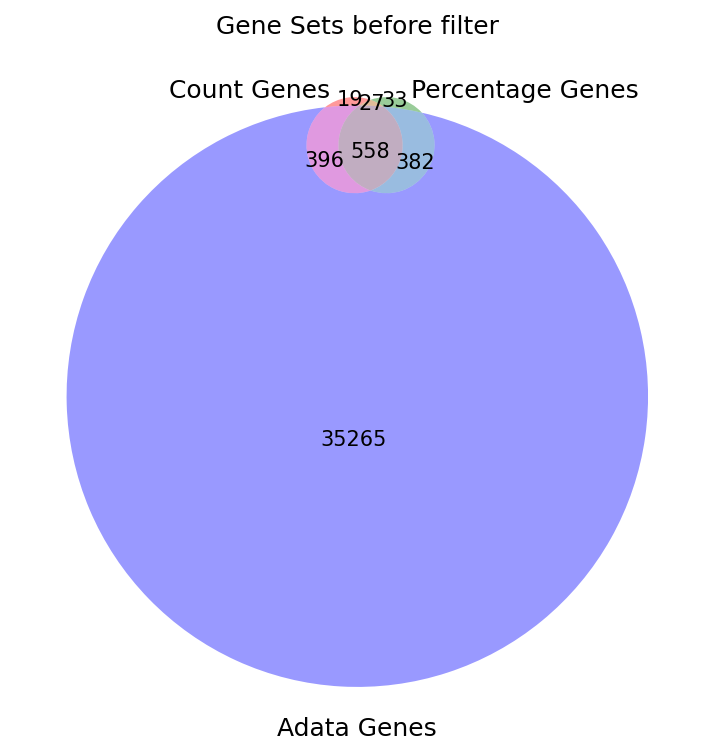

In [62]:
plt.figure(figsize=(6, 6))
venn3([gene_names_count, gene_names_perc, gene_names_adata], 
      ('Count Genes', 'Percentage Genes', 'Adata Genes'))

# Show the plot
plt.title("Gene Sets before filter")
plt.show()

In [59]:
sc.pp.filter_cells(adata, min_genes=250)
sc.pp.filter_genes(adata, min_cells=50)
gene_names_adata_filtered = set(adata.var_names.tolist())

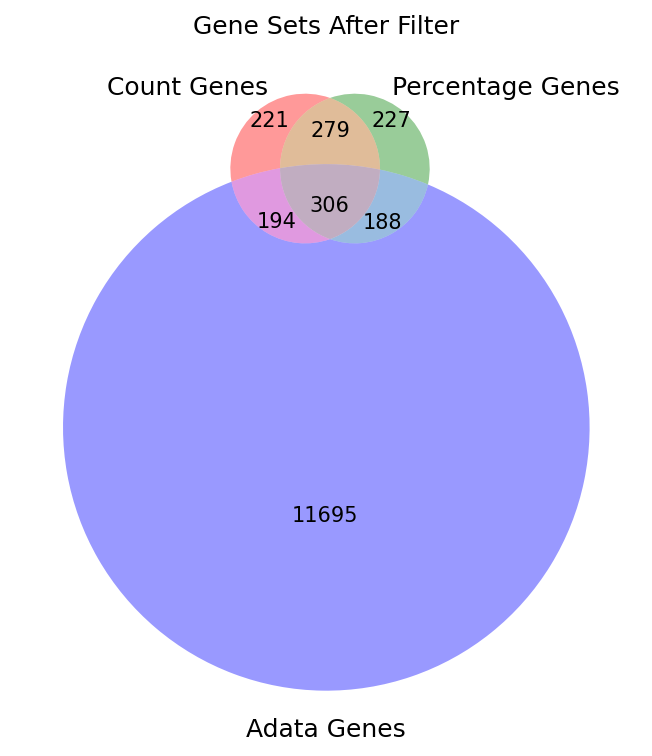

In [61]:
plt.figure(figsize=(6, 6))
venn3([gene_names_count, gene_names_perc, gene_names_adata_filtered], 
      ('Count Genes', 'Percentage Genes', 'Adata Genes'))

# Show the plot
plt.title("Gene Sets After Filter")
plt.show()